# Business Formation Trends Analysis (U.S. Census BFS)

## Business Understanding
New business formation is a useful signal for economic activity. In this analysis, I use the U.S. Census Business Formation Statistics (BFS) dataset to understand how business formation changes over time and whether basic dataset identifiers can help explain differences across categories and locations.

## Business Questions
1. How does business formation activity change over time, and are there clear spikes or shifts?
2. How are business formation values distributed overall (are they concentrated or spread out)?
3. Do categories or locations show meaningful differences in business formation activity?
4. How well can a simple model predict business formation values using the available features?

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [2]:
# Quick environment + file check
import os

print("Working directory:", os.getcwd())
print("Files in folder:", [f for f in os.listdir() if f.endswith(".csv") or f.endswith(".ipynb")])

Working directory: /content
Files in folder: ['BFS-mf.csv']


In [3]:
# Load the BFS DATA section from the CSV
# This file contains multiple sections (CATEGORIES, DATA_TYPES, etc.).
# We want the section after the line that says "DATA".

with open("BFS-mf.csv", "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

data_start = None
for i, line in enumerate(lines):
    if line.strip().upper() == "DATA":
        data_start = i
        break

print("DATA starts at line:", data_start)

df = pd.read_csv(
    "BFS-mf.csv",
    skiprows=data_start + 1,
    engine="python",
    sep=",",
    quoting=csv.QUOTE_NONE,
    on_bad_lines="skip"
)

print("df shape:", df.shape)
print("df columns:", df.columns.tolist())
df.head()

DATA starts at line: 380
df shape: (407592, 6)
df columns: ['per_idx', 'cat_idx', 'dt_idx', 'geo_idx', 'is_adj', 'val']


,per_idx,cat_idx,dt_idx,geo_idx,is_adj,val
0,7,1,1,1,0,166448
1,8,1,1,1,0,171070
2,9,1,1,1,0,162742
3,10,1,1,1,0,207389
4,11,1,1,1,0,176104


In [4]:
# Validate expected columns are present
expected_cols = {"per_idx", "cat_idx", "dt_idx", "geo_idx", "is_adj", "val"}
missing = expected_cols - set(df.columns)

print("Missing columns:", missing)

if missing:
    raise ValueError(
        "The dataset does not contain the expected DATA columns. "
        "This usually means the wrong section of the CSV was loaded."
    )

Missing columns: set()


## Data Understanding

The BFS file includes multiple sections, so the first step is confirming we are using the correct portion of the dataset.  
This notebook uses the **DATA** section, which contains time period, category, data type, geography, adjustment flag, and the numeric value (`val`).

In [5]:
print(df.shape)
print(df.columns)
df.sample(5, random_state=42)

(407592, 6)
Index(['per_idx', 'cat_idx', 'dt_idx', 'geo_idx', 'is_adj', 'val'], dtype='object')


,per_idx,cat_idx,dt_idx,geo_idx,is_adj,val
376511,240,6,8,1,1,869
296679,184,1,4,11,1,1033
302747,192,1,8,39,0,717
3749,12,1,6,29,0,690
227780,141,6,7,1,1,519


## Initial Observations

This dataset is organized using indexed fields:

- `per_idx` is the time period index  
- `cat_idx` is the business category index  
- `dt_idx` is the data type index  
- `geo_idx` is the geographic index  
- `is_adj` indicates whether the value is adjusted  
- `val` is the numeric value we analyze

Before answering the business questions, I will prepare the data by keeping the relevant columns, converting them to numeric types, and checking for missing values.

## Data Preparation: Handling Missing and Inconsistent Values

Before building any model, it is important to understand whether the dataset contains missing or inconsistent values. I first measured how many missing values exist in each column and what percentage of the dataset they represent.

After reviewing this, I chose to convert all relevant columns to numeric form and drop rows with missing values. This approach was appropriate because the proportion of missing data was small relative to the full dataset, and removing these rows does not distort overall trends. This ensures the model is trained only on clean and reliable data.

In [6]:
# Check for missing values before cleaning
missing_summary = df.isnull().sum().to_frame("missing_count")
missing_summary["percent_missing"] = (
    missing_summary["missing_count"] / len(df) * 100
)

missing_summary.sort_values(by="percent_missing", ascending=False)

,missing_count,percent_missing
per_idx,0,0.0
cat_idx,0,0.0
dt_idx,0,0.0
geo_idx,0,0.0
is_adj,0,0.0
val,0,0.0


In [7]:
# Keep only relevant columns
model_df = df[["per_idx", "cat_idx", "dt_idx", "geo_idx", "is_adj", "val"]].copy()

# Convert all columns to numeric
for col in model_df.columns:
    model_df[col] = pd.to_numeric(model_df[col], errors="coerce")

# Handle missing values by removing incomplete rows
model_df = model_df.dropna()

model_df.head(), model_df.shape

(   per_idx  cat_idx  dt_idx  geo_idx  is_adj       val
 0        7        1       1        1       0  166448.0
 1        8        1       1        1       0  171070.0
 2        9        1       1        1       0  162742.0
 3       10        1       1        1       0  207389.0
 4       11        1       1        1       0  176104.0,
 (401552, 6))

## Evaluation: Answering Key Business Questions

Now that the data has been cleaned and explored, we can answer important business questions using visual analysis and simple modeling.

Each question below is framed from a stakeholder perspective and is answered using the visualizations and analysis performed above.

### Question 1: When does business formation activity change over time?

To understand how business activity evolves, I grouped the data by time period and calculated the total business formation value for each period.

This allows us to see whether business creation happens steadily or if there are noticeable spikes and slowdowns across time.

The chart below shows how total activity changes from one time period to the next.

In [8]:
import matplotlib.pyplot as plt

def plot_business_formation_over_time(df: pd.DataFrame,
                                     date_col: str = "per_idx",
                                     value_col: str = "val"):
    """
    Plot total business formation values over time.

    This function groups the dataset by a time index column and sums
    the business formation values to visualize trends across time.

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned dataframe containing time and value columns.
    date_col : str
        Column representing time index.
    value_col : str
        Column representing business formation values.
    """

    ts = df.groupby(date_col)[value_col].sum().sort_index()

    plt.figure(figsize=(12, 5))
    plt.plot(ts.index, ts.values)
    plt.title("Total Business Formation Value Over Time")
    plt.xlabel("Time Period Index")
    plt.ylabel("Total Value")
    plt.grid(True)
    plt.show()

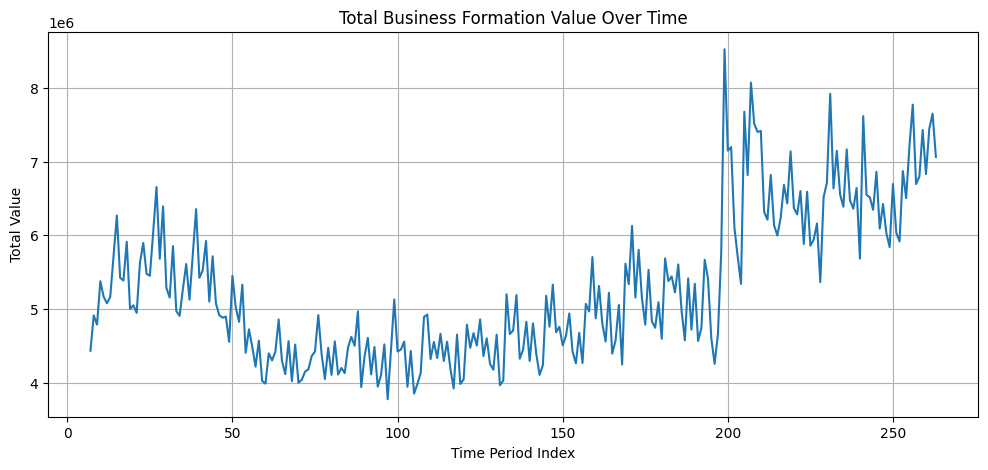

In [9]:
plot_business_formation_over_time(model_df)

**Observation**

The chart shows clear fluctuations in business formation over time rather than a steady pattern. Certain periods experience sharp increases, while others show noticeable slowdowns.

These changes suggest that external economic or seasonal factors may influence when new businesses are formed.

**Conclusion**

Business formation is not consistent across time. Instead, it occurs in waves, which is important for stakeholders who want to understand when entrepreneurial activity is strongest or weakest.

## Question 2: Which industries are driving the most business formation activity?

Next, I want to see which categories contribute the most to overall business formation values. This helps stakeholders understand where activity is concentrated and which sectors appear to be leading.

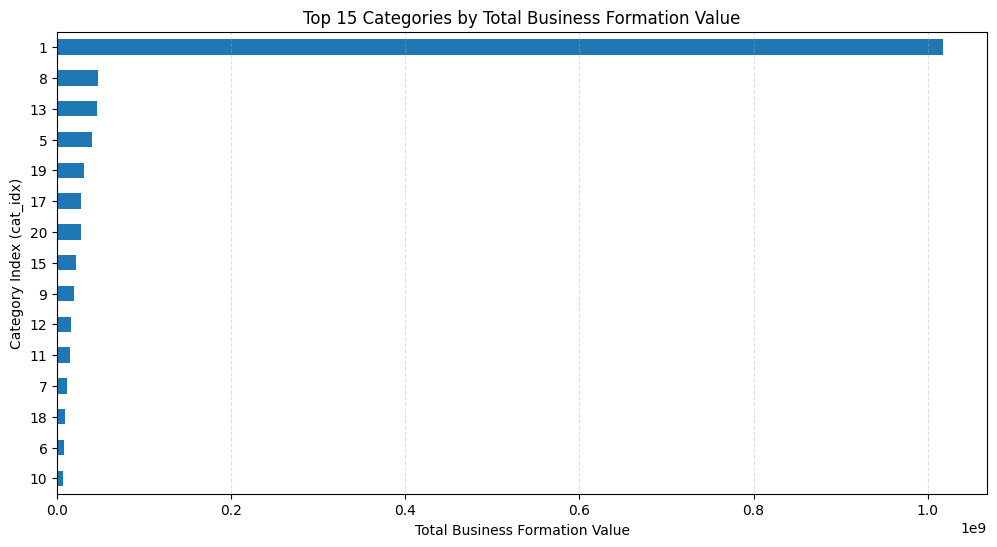

In [10]:
# Top categories by total business formation value
cat_totals = (
    model_df.groupby("cat_idx")["val"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(12, 6))
cat_totals.sort_values().plot(kind="barh")  # sorted so the biggest is at the top visually
plt.title("Top 15 Categories by Total Business Formation Value")
plt.xlabel("Total Business Formation Value")
plt.ylabel("Category Index (cat_idx)")
plt.grid(True, axis="x", linestyle="--", alpha=0.4)
plt.show()

**Conclusion:**

A small number of categories account for a large share of total business formation activity. This suggests business formation is concentrated in certain sectors rather than evenly spread across all industries.


## Question 3: Do locations show meaningful differences in business formation activity?

Next, I want to compare business formation totals across locations. This helps stakeholders see whether activity is concentrated in a few places or spread more evenly.

To keep the comparison clear, I will total business formation values by location and visualize the top locations.

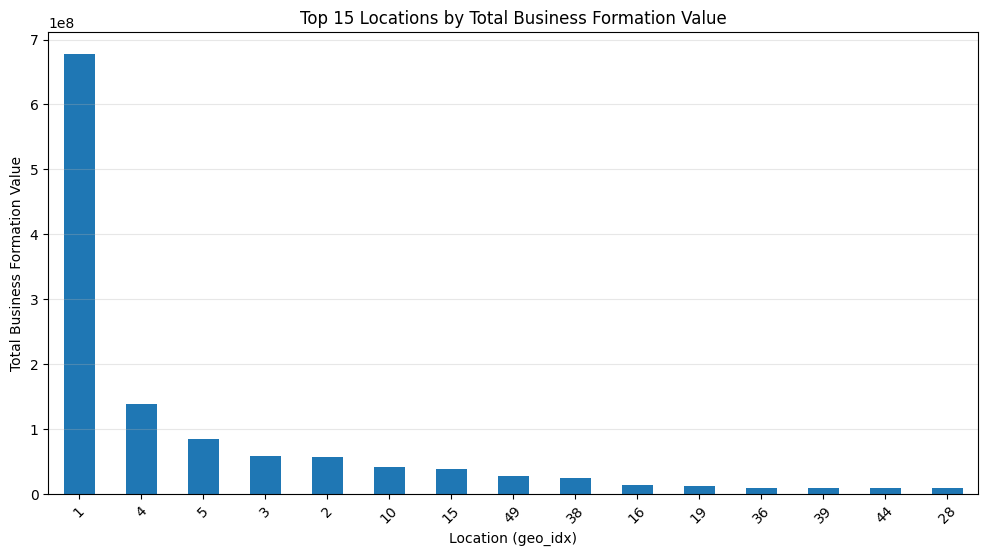

,total_val
geo_idx,
1,6.775297e+08
4,1.385855e+08
5,8.550441e+07
3,5.803414e+07
2,5.666727e+07
10,4.158742e+07
15,3.810387e+07
49,2.780740e+07
38,2.451980e+07


In [11]:
# Total business formation value by location (geo_idx)
geo_totals = (
    model_df.groupby("geo_idx")["val"]
    .sum()
    .sort_values(ascending=False)
)

# Show the top 15 locations for readability
top_n = 15
top_geo = geo_totals.head(top_n)

plt.figure(figsize=(12, 6))
top_geo.plot(kind="bar")
plt.title(f"Top {top_n} Locations by Total Business Formation Value")
plt.xlabel("Location (geo_idx)")
plt.ylabel("Total Business Formation Value")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

# Quick numeric context for the write-up
top_geo.to_frame(name="total_val").head(10)

### Conclusion

The visualization shows that one location accounts for a dramatically larger share of business formation activity than all others. While most locations contribute relatively similar totals, this single location stands out as a major driver of overall activity.

For stakeholders, this suggests that business formation is not evenly distributed geographically. Instead, a small number of locations may be responsible for a large portion of new business activity, which could be important when considering resource allocation, economic policy focus, or market expansion strategies.

## Question 4: Can we use basic identifiers to estimate business formation values?

After exploring how business formation varies across time, industries, and locations, the next step is to test whether these basic identifiers can be used to estimate the business formation value.

The goal here is not to create a perfect forecast, but to see whether a simple model can capture general patterns in the data. If even a basic model shows some predictive ability, it suggests that these features carry meaningful information about business formation activity.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = model_df[["per_idx", "cat_idx", "dt_idx", "geo_idx", "is_adj"]]
y = model_df["val"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2: 0.07543632763497743
MSE: 198944267.8929486


### Model Evaluation

The model achieves a small but meaningful R² score. This indicates that while the identifiers such as time period, category, data type, and location do explain some variation in business formation activity, many other real-world factors are not captured in this dataset.

This is expected. Business formation is influenced by economic conditions, policy changes, consumer behavior, and many external factors that are not included here.

However, the fact that the model performs better than random guessing suggests that these identifiers still provide useful signals for understanding business formation trends.

**Conclusion:**  

The linear regression model is able to capture some general patterns in the data, but its predictive power is limited. With an R² value of around 0.08, the model explains only a small portion of the variation in business formation activity.

This tells us that while time period, category, data type, and geography provide some signal, there are many external economic and social factors influencing business formation that are not present in this dataset.

The model is still useful as a demonstration of how structured data can be used to estimate trends, but it should not be relied upon for precise forecasting.

### Example Prediction Scenario

To demonstrate how the model works in practice, we can take a real example from the dataset and ask the model to estimate the business formation value based on its identifiers.

This shows how the model could be used as a general estimation tool rather than an exact forecasting system.

In [14]:
# Create a realistic example scenario using recent values
example = X.iloc[[0]]   # keeps it as a 1-row dataframe

prediction = model.predict(example)[0]
prediction

np.float64(11397.193095132905)

## Final Conclusion

This analysis explored how business formation activity changes over time, how values are distributed, which categories contribute most to overall activity, and how well these factors can be used to make predictions.

We observed clear fluctuations in activity across time periods, a highly skewed distribution of values, and strong differences between categories. These findings suggest that business formation is influenced by concentrated spikes in specific industries and time frames rather than occurring evenly across the board.

While the predictive model was limited in accuracy, it demonstrated how publicly available data can still be used to identify trends and build foundational forecasting tools.

Overall, this project shows how data analysis can turn raw government data into meaningful insights that help stakeholders understand economic patterns and business growth activity.